In [4]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib notebook

import matplotlib.units as munits
import matplotlib.dates as mdates
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter


In [5]:
my_data = np.genfromtxt('COVID19.csv', delimiter=',', converters={0: lambda x: np.datetime64(x)})

date = np.array([d[0] for d in my_data[1:]])
cases = np.array([d[1] for d in my_data[1:]])
deaths = np.array([d[2] for d in my_data[1:]])
casesVI = np.array([d[3] for d in my_data[1:]])

tests = np.array([d[4] for d in my_data[1:]])
yday = (date-np.datetime64('2020-01-01')).astype('float')


print(cases)

[  6.   7.   8.  11.  12.  18.  27.  53.  64.  73. 103. 186. 231. 271.
 348.]


<IPython.core.display.Javascript object>


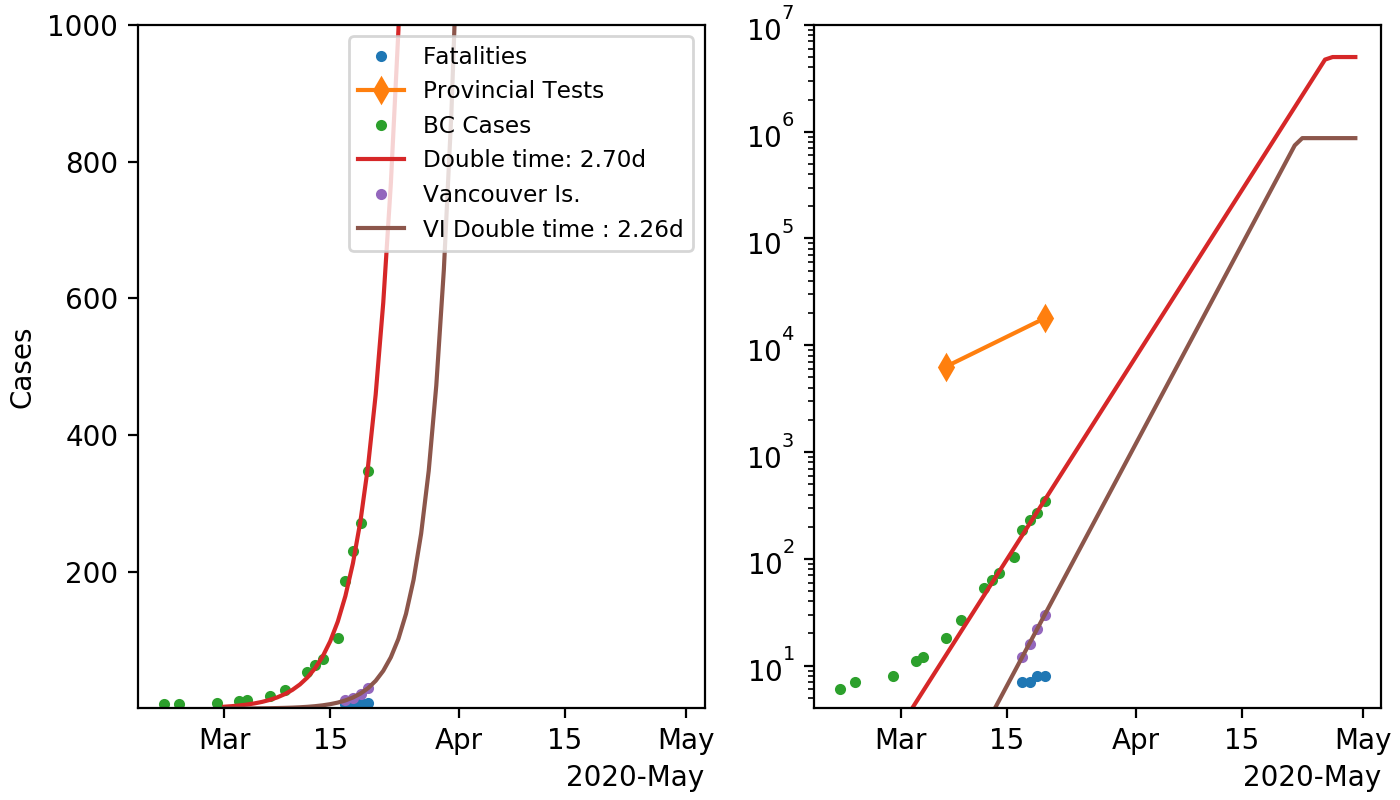

/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':
/Users/jklymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4), sharex=True, constrained_layout=True)

for nn in range(2):
    ax = axs[nn]
    
    ax.semilogy(date, deaths, '.', label='Fatalities')

    ax.semilogy(date[np.isfinite(tests)], tests[np.isfinite(tests)], 'd-', label='Provincial Tests')

    ax.semilogy(date, cases, '.', label='BC Cases')

    ax.set_ylim(0, 400)

    daysago=7
    t0 = yday[-daysago]
    cases0 = cases[-daysago]
    p = np.polyfit(yday[-daysago:]-t0, np.log(cases[-daysago:]), 1)
    tau = 1/p[0]
    cases0 = np.exp(p[1])
    dd = np.arange('2020-03', '2020-05', dtype='datetime64[D]')

    ddy = (dd-np.datetime64('2020-01-01')).astype('float')
    possiblecases = cases0*np.exp((ddy-t0)/tau)
    possiblecases = np.clip(possiblecases, 0, 5e6)
    ax.plot(dd, possiblecases, label=f'Double time: {np.log(2) * tau:1.2f}d')

    # VI
    good = np.isfinite(casesVI)
    ydayVI = yday[good]
    t = ydayVI-ydayVI[0]
    p = np.polyfit(t, np.log(casesVI[good]), 1)
    tauVI = 1/p[0]
    cases0VI = np.exp(p[1])
    ax.semilogy(date, casesVI, '.', label='Vancouver Is.')

    fitcases = cases0VI*np.exp((ddy-ydayVI[0])/tauVI)
    fitcases = np.clip(fitcases, 0, 870297)

    ax.plot(dd, fitcases, label=f'VI Double time : {np.log(2) * tauVI:1.2f}d')


    if nn == 0:
        ax.set_ylim(1, 1000)
        ax.set_yscale('linear')    
        ax.legend(loc=1, fontsize='small')
    else:
        ax.set_ylim(0, 1e7)
        ax.set_yscale('log')
axs[0].set_ylabel('Cases')
fig.savefig('Cases.pdf')

fig.savefig('Cases.png')

!open Cases.pdf


$ c = a\ e^{\frac{t-t_0}{\tau}}$ 

$log(c) = log(a) + (t-t_0)/\tau$

$exp((t-t0)/tau) = 2$
$t-t0 = np.log(2) * tau$
